In [1]:
import tensorflow as tf
import gpflow
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')

In [85]:
class SpectralMixture(gpflow.kernels.Stationary): # stationary, eucl_dist
    def __init__(self, q=1):
        gpflow.kernels.Stationary.__init__(self, input_dim=1, active_dims=[0], lengthscales=1.0)
        self.q = q
        self.w = gpflow.param.ParamList([gpflow.param.Param(np.random.random(1)[0],
                                                            transform=gpflow.transforms.positive) for i in range(q)])
        self.sigma_upp = gpflow.param.ParamList([gpflow.param.Param(np.random.random(1)[0],
                                                            transform=gpflow.transforms.positive) for i in range(q)])
        self.mu = gpflow.param.ParamList([gpflow.param.Param(np.random.random(1)[0]) for i in range(q)])

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            X2 = X
        tau = X-tf.transpose(X2)
        ans = 0
        for i in range(self.q):
            ans += self.w[i] * tf.exp(tf.negative(self.sigma_upp[i] * tf.square(tau))) * tf.cos(self.mu[i] * tau)
        return ans

    def Kdiag(self, X):
        ans = 0
        for i in range(self.q):
            ans += self.w[i]
        return np.sum(self.w) # correct?

## Test

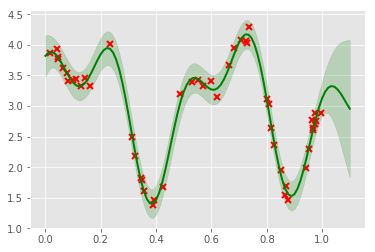

In [89]:
N = 50
X = np.random.rand(N, 1)
f = lambda u: (np.sin(u))
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3

k = SpectralMixture(q=8)

m = gpflow.gpr.GPR(X, Y, kern=k)
    
m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=10000)
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2, c='r')
line, = plt.plot(xx, mean, lw=2, c='g')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)

## sin

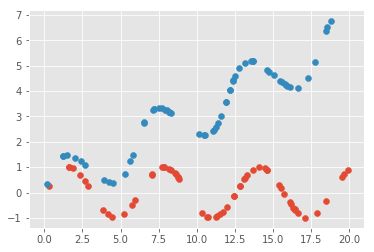

In [11]:
N = 60
X = np.random.uniform(0, 20, size=(N, 1))
f = lambda u: (np.sin(u))
Y = f(X) #+ np.random.randn(N,1)*0.1 + 3
alpha = 0.3
plt.scatter(X,Y)
X_ = X*np.cos(alpha)-Y*np.sin(alpha)
Y_ = X*np.sin(alpha)+Y*np.cos(alpha)
plt.scatter(X_, Y_)

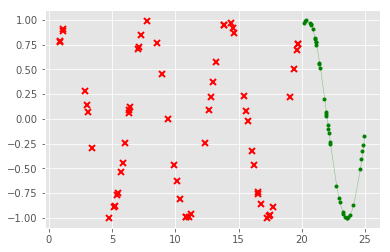

In [5]:
k = SpectralMixture(q=4)
    
m = gpflow.gpr.GPR(X, Y, kern=k)
m.optimize()

xx = np.random.uniform(20, 25, size=(40, 1))
mean, var = m.predict_y(xx)
plt.plot(X, Y, 'kx', mew=2, c='r')
I = np.argsort(xx[:,0])
line, = plt.plot(xx, mean, '.g', lw=2)
_ = plt.fill_between(xx[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), alpha=0.2)

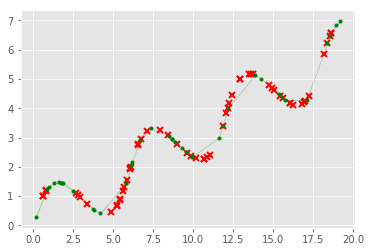

In [6]:
q = 4
k = SpectralMixture()
for i in range(q):
    k += SpectralMixture()
    
m = gpflow.gpr.GPR(X_, Y_, kern=k)
m.optimize()

xx = np.random.uniform(0, 20, size=(40, 1))
mean, var = m.predict_y(xx)
plt.plot(X_, Y_, 'kx', mew=2, c='r')
I = np.argsort(xx[:,0])
line, = plt.plot(xx, mean, '.g', lw=2)
_ = plt.fill_between(xx[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), alpha=0.2)

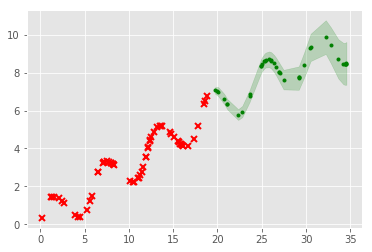

In [15]:
k = SpectralMixture(q=5)
    
m = gpflow.gpr.GPR(X_, Y_, kern=k)
m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=6000)

xx = np.random.uniform(18, 35, size=(40, 1))
mean, var = m.predict_y(xx)
plt.plot(X_, Y_, 'kx', mew=2, c='r')
I = np.argsort(xx[:,0])
line, = plt.plot(xx, mean, '.g', lw=2)
_ = plt.fill_between(xx[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), alpha=0.2)

## CO_2

In [13]:
def get_co2_data(train_len=300, in_order=True):
    data = pd.read_csv('CO2 concentration.txt', sep=" ", header=None)
    data = data.drop([0, 13, 14], axis=1) # years, annual, annual fit
    points = data.values.reshape((-1,))
    points = points[points > 0]
    points = (points - np.mean(points))/np.std(points) # standarize data

    X = np.arange(len(points), dtype=float).reshape((len(points), 1))
    indices = np.random.permutation(X.shape[0]) if not in_order else np.arange(0, X.shape[0])
    indices = indices.reshape((-1,1))
    X_train = indices[0:train_len].astype(float)
    Y_train = points[indices[0:train_len]].reshape((train_len, 1))
    X_pred = indices[train_len:].astype(float)
    Y_true = points[indices[train_len:]].reshape((-1,))
    return X_train, Y_train, X_pred, Y_true

def my_plot(mean, var):
    plt.figure(figsize=(13, 6))
    plt.plot(X_train, Y_train, '.r', label='train')
    plt.plot(X_pred, Y_true, '.b', label='true')
    I = np.argsort(X_pred[:,0])
    line, = plt.plot(X_pred[I,0], mean[I,0], lw=2, c='g', label='pred')
    plt.fill_between(X_pred[I,0], mean[I,0] - 2*np.sqrt(var[I,0]), 
                     mean[I,0] + 2*np.sqrt(var[I,0]), color=line.get_color(), 
                     alpha=0.2, label='variance')
    plt.legend()

### Different ranges

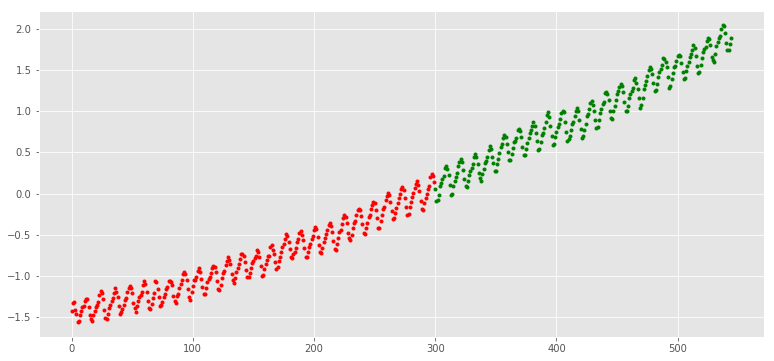

In [14]:
X_train, Y_train, X_pred, Y_true = get_co2_data()
plt.figure(figsize=(13,6))
plt.plot(X_train, Y_train, '.r')
plt.plot(X_pred, Y_true, '.g')

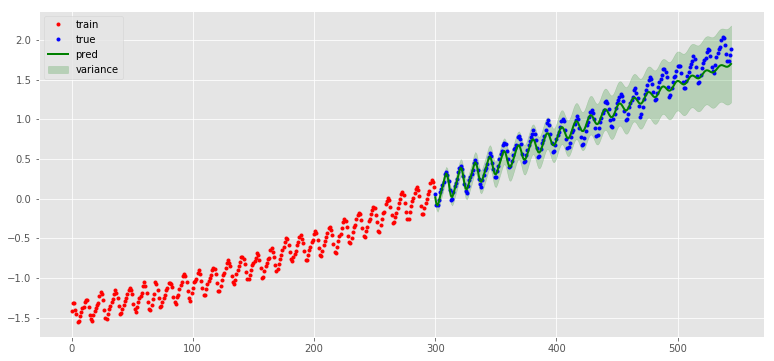

In [53]:
q = 7
k = SpectralMixture()
for i in range(1, q):
    k += SpectralMixture()

m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
m.optimize(method=tf.train.AdamOptimizer(0.03), maxiter=10000)

mean, var = m.predict_y(X_pred)
my_plot(mean, var)

Caught KeyboardInterrupt, setting model                  with most recent state.


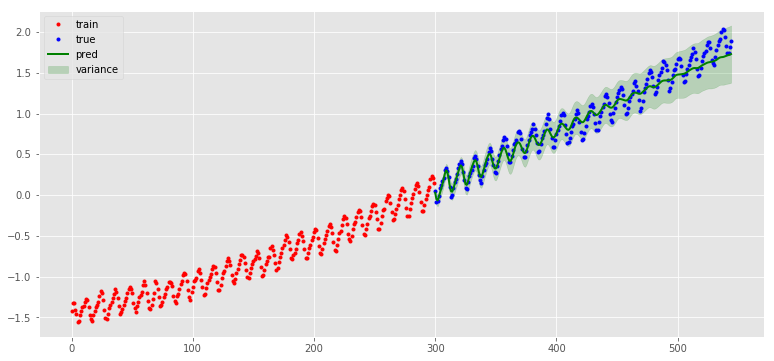

In [23]:
k = SpectralMixture(q=8)

m = gpflow.gpr.GPR(X_train, Y_train, kern=k)
m.optimize(method=tf.train.AdamOptimizer(0.03), maxiter=15000)

mean, var = m.predict_y(X_pred)
my_plot(mean, var)

## MOSM

In [2]:
class MOSpectralMixture(gpflow.kernels.Stationary): # stationary, eucl_dist
    def __init__(self, m):
        gpflow.kernels.Stationary.__init__(self, input_dim=1, active_dims=[0], lengthscales=1.0)
        self.m = m
        self.w = gpflow.param.Param(np.random.random((m,)), transform=gpflow.transforms.positive)
        self.sigma = gpflow.param.Param(np.random.random((m,)), transform=gpflow.transforms.positive)
        self.mu = gpflow.param.Param(np.random.random((m,)))
        self.theta = gpflow.param.Param(np.random.random((m,)))
        self.phi = gpflow.param.Param(np.random.random((m,)))
    
    def get_correlated_parameters(self, I, len_I, I2, len_I2):
        '''Returns matrices with the corresponding correleted parameters in each position'''
        i = tf.tile(I, [1, len_I2])
        j = tf.tile(tf.transpose(I2), [len_I, 1])
        sigma_i = tf.gather(self.sigma, i)
        sigma_j = tf.gather(self.sigma, j)
        sigma_ij = tf.div(2*sigma_i*sigma_j, sigma_i + sigma_j)
        mu_i = tf.gather(self.mu, i)
        mu_j = tf.gather(self.mu, j)
        mu_ij = tf.div(sigma_i*mu_j + sigma_j*mu_i, sigma_i + sigma_j)
        w_i = tf.gather(self.w, i)
        w_j = tf.gather(self.w, j)
        w_ij = w_i*w_j*tf.exp(tf.div(-0.25*tf.square(mu_i - mu_j), sigma_i + sigma_j))
        theta_ij = tf.gather(self.theta, i) - tf.gather(self.theta, j)
        phi_ij = tf.gather(self.phi, i) - tf.gather(self.phi, j)
        return sigma_ij, mu_ij, w_ij, theta_ij, phi_ij

    def K(self, X, X2=None, presliced=False):
        if X2 is None:
            X2 = X
        points_x = tf.reshape(X[:,0], (-1,1))
        points_x2 = tf.reshape(X2[:,0], (-1,1))
        tau = tf.tile(points_x, [1, tf.shape(X2)[0]]) -\
              tf.tile(tf.transpose(points_x2), [tf.shape(X)[0], 1])
        I_X = tf.cast(tf.reshape(X[:,1], (-1,1)), dtype=tf.int32)
        I_X2 = tf.cast(tf.reshape(X2[:,1], (-1,1)), dtype=tf.int32)
        sigma_ij, mu_ij, w_ij, theta_ij, phi_ij = self.get_correlated_parameters(I_X, tf.shape(X)[0],
                                                                                 I_X2, tf.shape(X2)[0])
        alpha_ij = tf.scalar_mul((np.float64(2*np.pi))**0.5, w_ij*tf.abs(sigma_ij))
        return alpha_ij*tf.exp(tf.negative((tau + theta_ij)**2*sigma_ij))*\
                tf.cos((tau + theta_ij)*mu_ij + phi_ij)

    def Kdiag(self, X):
        # tau = theta_ij = phi_ij = 0 -> return alpha_ij
        I = tf.transpose(tf.cast(tf.reshape(X[:,1], (-1,1)), dtype=tf.int32))
        w_i = tf.square(tf.gather(self.w, I))
        sigma_i = tf.gather(self.sigma, I)
        return tf.scalar_mul((np.float64(2*np.pi))**0.5, w_i*tf.abs(sigma_i))

In [3]:
N = 50
X = np.random.rand(N, 1)
f = lambda u: (np.sin(u))
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N, 1)*0.1 + 3

q = 7
I = np.zeros((X.shape[0], 1), dtype=np.int64)
k = MOSpectralMixture(m=1)
for i in range(1, q):
    k += MOSpectralMixture(m=1)

m = gpflow.gpr.GPR(np.concatenate((X, I), axis=1), Y, kern=k)

_ = m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=6000)

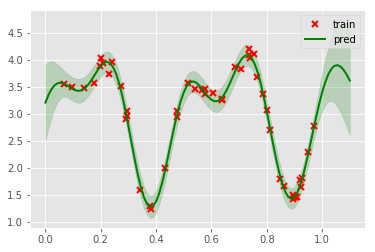

In [6]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.zeros((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X, Y, 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

## Two channels

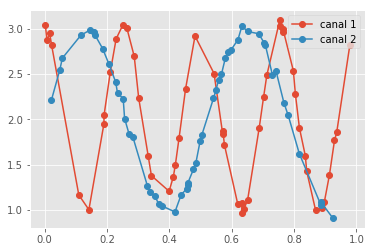

In [74]:
N = 50
X1 = np.random.rand(N,)
X2 = np.random.rand(N,)
Y1 = np.cos(25*X1) + np.random.randn(N,)*0.05 + 2
Y2 = np.sin(12*X2) + np.random.randn(N,)*0.05 + 2
I = np.argsort(X1)
plt.plot(X1[I], Y1[I], '-o', label='canal 1')
I = np.argsort(X2)
plt.plot(X2[I], Y2[I], '-o', label='canal 2')
plt.legend()

In [75]:
X = np.concatenate((np.reshape(X1, [N,1]), np.reshape(X2, [N,1])), axis=0)
Y = np.concatenate((np.reshape(Y1, [N,1]), np.reshape(Y2, [N,1])), axis=0)
I = np.concatenate((np.zeros((N, 1), dtype=np.int64),
                    np.ones((N, 1), dtype=np.int64)), axis=0)
k = MOSpectralMixture(m=2)
q = 7
for i in range(1, q):
    k += MOSpectralMixture(m=2)

m = gpflow.gpr.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
_ = m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=15000)

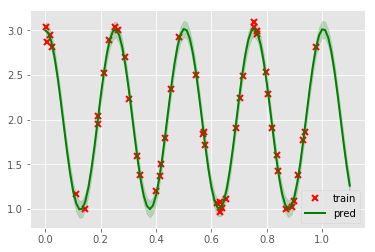

In [76]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.zeros((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[0:50], Y[0:50], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

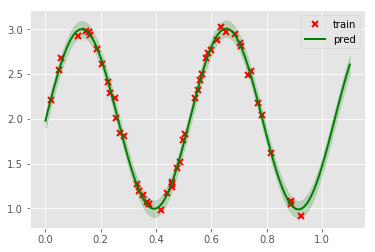

In [77]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.ones((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[50:100], Y[50:100], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

## Other two channels

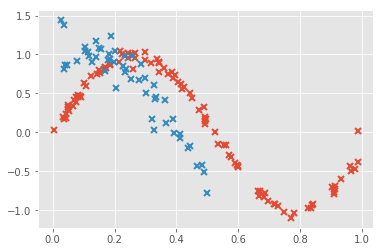

In [78]:
X1 = np.random.rand(100, 1)
X2 = np.random.rand(50, 1) * 0.5
Y1 = np.sin(6*X1) + np.random.standard_t(3, X1.shape)*0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.standard_t(3, X2.shape)*0.1

plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)

In [82]:
N1 = 100
N2 = 50

In [80]:
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)
I = np.concatenate((np.zeros((N1, 1), dtype=np.int64),
                    np.ones((N2, 1), dtype=np.int64)), axis=0)
k = MOSpectralMixture(m=2)
q = 7
for i in range(1, q):
    k += MOSpectralMixture(m=2)

m = gpflow.gpr.GPR(np.concatenate((X, I), axis=1), Y, kern=k)
_ = m.optimize(method=tf.train.AdamOptimizer(0.01), maxiter=15000)

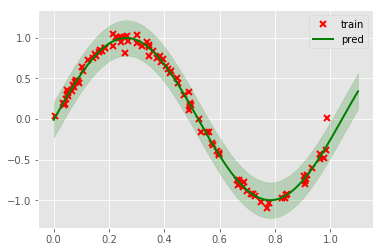

In [83]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.zeros((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[0:N1], Y[0:N1], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()

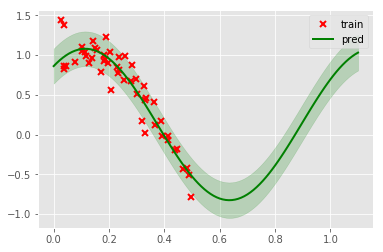

In [84]:
xx = np.linspace(0, 1.1, 100).reshape(100, 1)
i_xx = np.ones((xx.shape[0], 1), dtype=np.int64)
mean, var = m.predict_y(np.concatenate((xx, i_xx), axis=1))
plt.plot(X[N1:], Y[N1:], 'kx', mew=2, c='r', label='train')
line, = plt.plot(xx, mean, lw=2, c='g', label='pred')
_ = plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), 
                     mean[:,0] + 2*np.sqrt(var[:,0]), color=line.get_color(), alpha=0.2)
plt.legend()